# Predicting titanic passengers which will survive
In this notebook, we will analyze a dataset about titanic passengers and we will make a model which will predict which passengers will survive.
## Features:

- survival - Survival (0 = No, 1 = Yes)
- pclass - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- sex - Sex
- Age - Age in years
- sibsp - # of siblings / spouses aboard the Titanic
- parch - # of parents / children aboard the Titanic
- ticket - Ticket number
- fare - Passenger fare
- cabin - Cabin number
- embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### Additional Info

**pclass**: A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

## Target column:

- survival 

# Imports

In [434]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from jsonschema.validators import create
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import OneClassSVM

# Importing the dataset

In [435]:
df = pd.read_csv('train.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [436]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


As we see by this table, age column has 177 null columns.

In [437]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Preprocessing the data
### Dropping columns
As we see, passenger id, name and ticket number, we neither can encode them nor they are useful for our analysis.

In [438]:
df = df.drop('Name', axis=1)
df = df.drop('PassengerId', axis=1)
df = df.drop('Ticket', axis=1)

Embarked should be encoded with LabelEncoder.

In [439]:
one_hot_encoder = OneHotEncoder()
encoded = one_hot_encoder.fit_transform(df[['Sex']])
categories = one_hot_encoder.categories_[0]
df['Sex'] = encoded[:, 0].toarray().flatten()
label_encoder = LabelEncoder()
df['Embarked'] = label_encoder.fit_transform(df['Embarked'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,0.0,22.0,1,0,7.2500,NaN,2
1,1,1,1.0,38.0,1,0,71.2833,C85,0
2,1,3,1.0,26.0,0,0,7.9250,NaN,2
3,1,1,1.0,35.0,1,0,53.1000,C123,2
4,0,3,0.0,35.0,0,0,8.0500,NaN,2


Visualizing cabin unique values:

In [440]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

There are 3 key observations of this values: 
- The cabin has a letter which may be a sector meaning and a number
- There are cabins with with no number 
- And there are merged cabins, example B57 B59 B63 B66
I will try to save this datas separately: sector and number will be saved separately and since in dataset we have up to 3 cabins merged, I will save those in additional columns.  

In [441]:
def process_single_cabin(cabin_val):
    if pd.isnull(cabin_val) or cabin_val == '':
        return [-1, -1, -1, -1 ,-1, -1]
    cabins = str(cabin_val).split()
    result = []
    
    for i in range(min(3, len(cabins))):
        cabin_str = cabins[i]
        if cabin_str:
            sector = cabin_str[0]
            number = cabin_str[1:] if len(cabin_str) > 1 else -1
        else:
            sector, number = -1, -1
        result.extend([sector, number])
    
    while len(result) < 6:
        result.extend([-1, -1])
        
    return result

cabin_data = []
for i in range(len(df)):
    cabin_val = df.loc[i, 'Cabin']
    cabin_data.append(process_single_cabin(cabin_val))
    
cabin_df = pd.DataFrame(
    cabin_data,
    columns=['Sector 1', 'Number 1', 'Sector 2', 'Number 2', 'Sector 3', 'Number 3']
)

df = pd.concat([df, cabin_df], axis=1)
label_encoder = LabelEncoder()

all_sectors = []
for col in ['Sector 1', 'Sector 2', 'Sector 3']:
    string_mask = df[col].apply(lambda x: isinstance(x, str))
    string_values = df.loc[string_mask, col]
    all_sectors.extend(string_values.tolist())

label_encoder.fit(all_sectors)

for col in ['Sector 1', 'Sector 2', 'Sector 3']:
    transformed_col = df[col].copy()
    
    string_mask = transformed_col.apply(lambda x: isinstance(x, str))
    string_indices = string_mask[string_mask].index
    transformed_col.loc[string_indices] = label_encoder.transform(transformed_col.loc[string_indices])  
    df[col] = transformed_col

# Drop original column
df.drop('Cabin', axis=1, inplace=True)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sector 1,Number 1,Sector 2,Number 2,Sector 3,Number 3
0,0,3,0.0,22.0,1,0,7.2500,2,-1,-1,-1,-1,-1,-1
1,1,1,1.0,38.0,1,0,71.2833,0,2,85,-1,-1,-1,-1
2,1,3,1.0,26.0,0,0,7.9250,2,-1,-1,-1,-1,-1,-1
3,1,1,1.0,35.0,1,0,53.1000,2,2,123,-1,-1,-1,-1
4,0,3,0.0,35.0,0,0,8.0500,2,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0.0,27.0,0,0,13.0000,2,-1,-1,-1,-1,-1,-1
887,1,1,1.0,19.0,0,0,30.0000,2,1,42,-1,-1,-1,-1
888,0,3,1.0,NaN,1,2,23.4500,2,-1,-1,-1,-1,-1,-1
889,1,1,0.0,26.0,0,0,30.0000,0,2,148,-1,-1,-1,-1


In [442]:
df.fillna(-1, inplace=True)
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Sector 1', 'Number 1', 'Sector 2', 'Number 2', 'Sector 3',
       'Number 3'],
      dtype='object')

# Data visualization
## Scatter plot

<Axes: xlabel='Fare', ylabel='Age'>

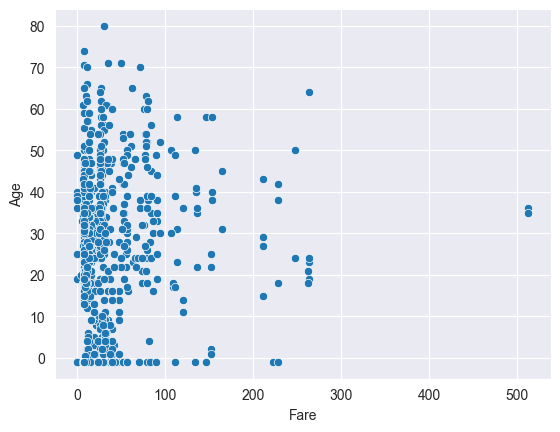

In [443]:
sns.scatterplot(x="Fare", y="Age", data=df)


Besides the fact that we see that most bought tickets are in the range between 0-100, we also see that more expensive tickets are bought by young adults. There are tickets sold for above 500, those could be some outliers.
## Contour plots 

<Axes: xlabel='Age', ylabel='Survived'>

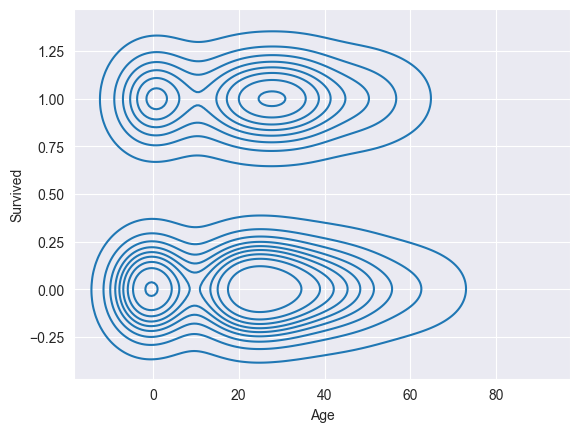

In [444]:
sns.kdeplot(x=df['Age'], y=df['Survived'])

Judging by the different length of the shapes, the oldest people who didn't survive are older than the oldest people that survived, also there is less data for people between ages of 20-30 who didn't survive.
## Histogram

<Axes: xlabel='Pclass', ylabel='Fare'>

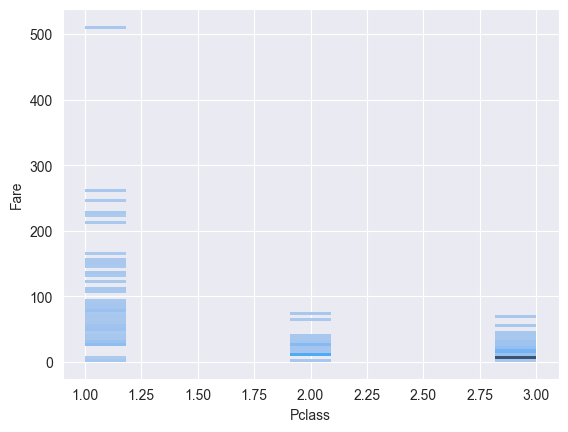

In [445]:
 sns.histplot(data=df, x='Pclass', y='Fare', stat='count')

As expected, fares for first class are higher than second and third class.
### Boxplot

<Axes: xlabel='Survived', ylabel='Age'>

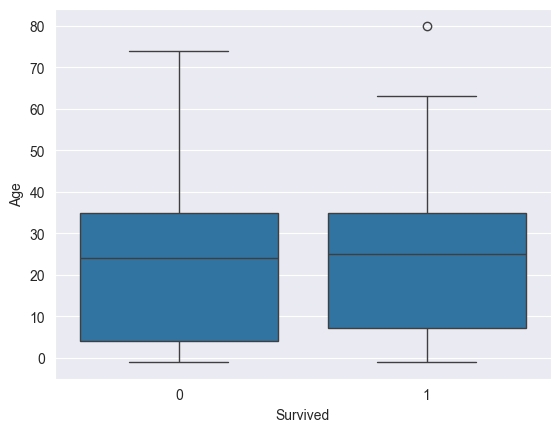

In [446]:
sns.boxplot(data=df, x='Survived', y='Age')

We see that people that survived are generally younger and passengers that are above 60 are considered outliers.
### Violinplot
Now, let's same data but with violinplot.

<Axes: xlabel='Survived', ylabel='Age'>

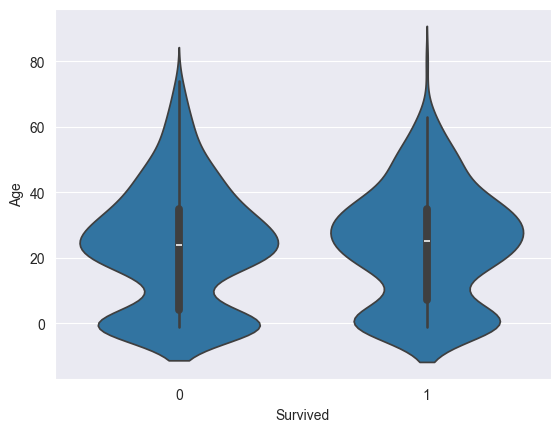

In [447]:
sns.violinplot(data=df, x='Survived', y='Age')

In this plot we can see, that young adults are the main demographic. Also we see that there are more children that survived than didn't.
### Pairplot


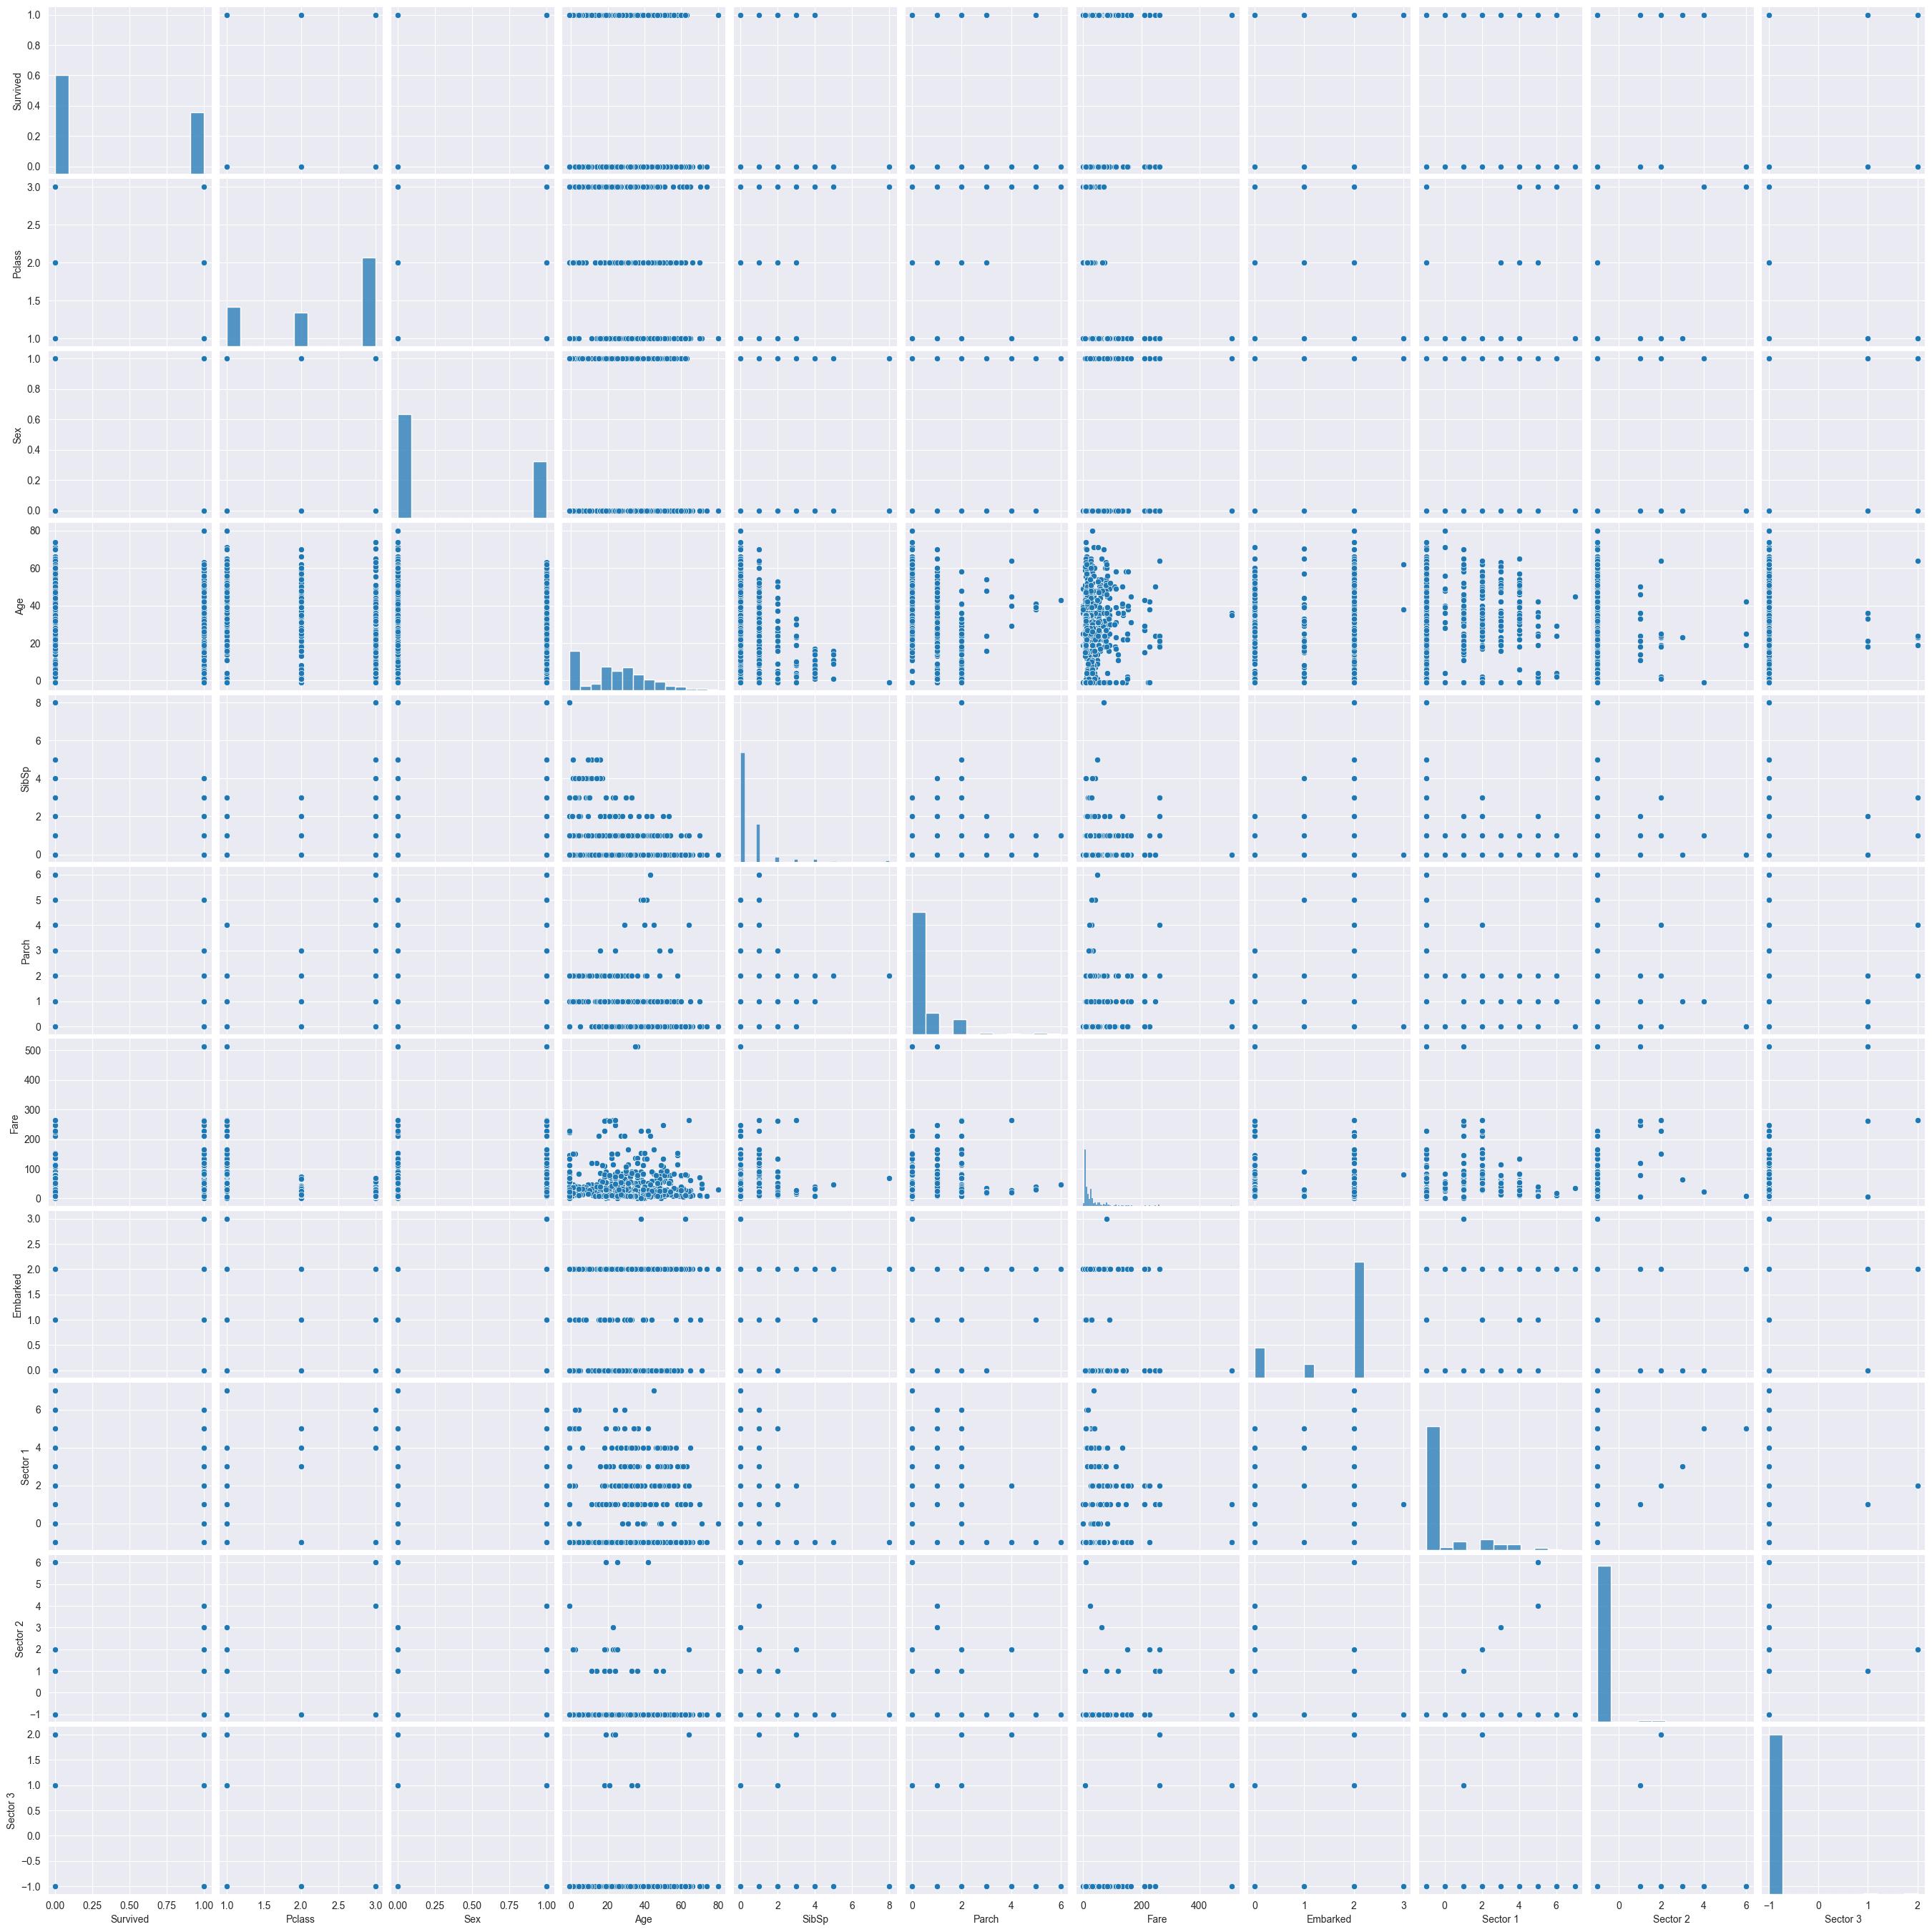

In [448]:
sns.pairplot(data=df)

In this plot, we can see the relations between each pair of attributes(we see some of plots we made before). Some observations: most people are in third class, have mostly no siblings or parents abroad, more people didn't survive.


### Age distribution

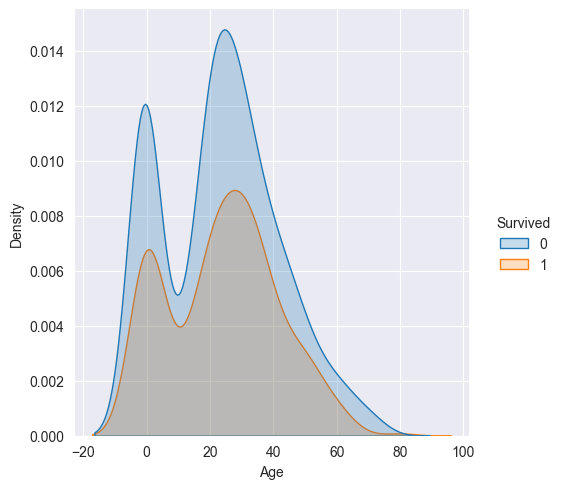

In [449]:
sns.displot(df, x="Age", hue="Survived", kind="kde", fill=True)

Young adults in range 20-35, tends to be the majority age group but also the group with both most survived and not survived. Also there seems to be more children/teenagers that survived over that not survived.

### Count of survived by gender


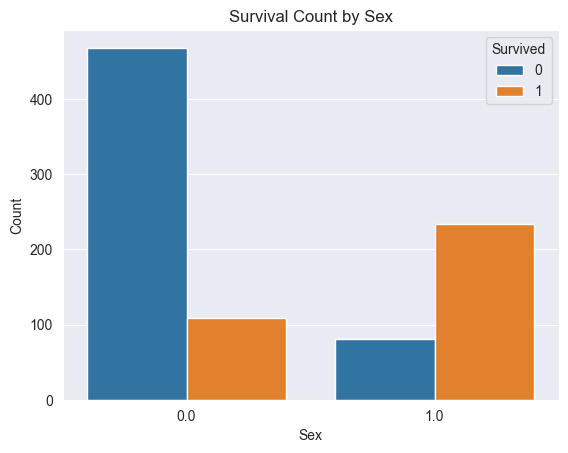

In [450]:
sns.countplot(data=df, x="Sex", hue="Survived")
plt.title('Survival Count by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

As expected, there are more females on the board and many more of them survived.
### Survived vs Fare 

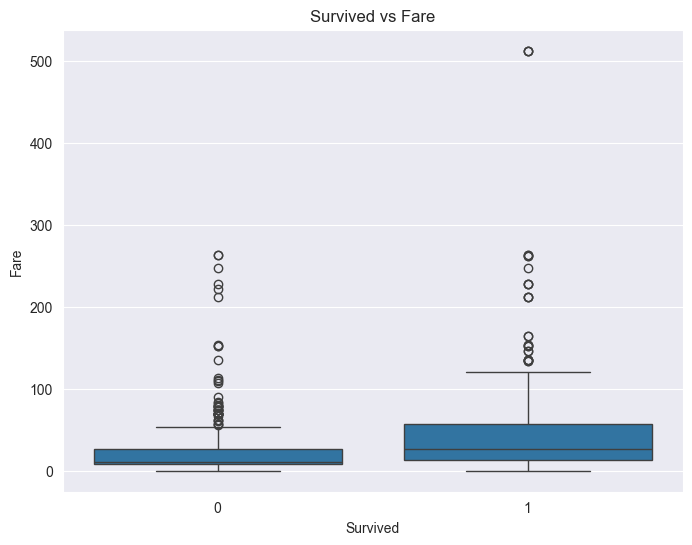

In [451]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title('Survived vs Fare')
plt.show()

If we were, to blindly judge by the plot, we have too many outliers in both categories. That means that we shouldn't blindly delete them just based on this plot. 

# Training models
I will use 4 models: Logistic Regression, SVM, Random Forest and Gradient Boosting

In [452]:
X_columns = ['Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Sector 1', 'Number 1', 'Sector 2', 'Number 2', 'Sector 3',
       'Number 3', 'Pclass', 'Sex', ]
X_train, X_test, y_train, y_test = train_test_split(df[X_columns],
                                                    df['Survived'],
                                                    test_size=0.2,
                                                    random_state=42)
def create_confusion_matrix(predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'])
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    plt.show()

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       105
           1       0.76      0.73      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.79      0.79      0.79       179



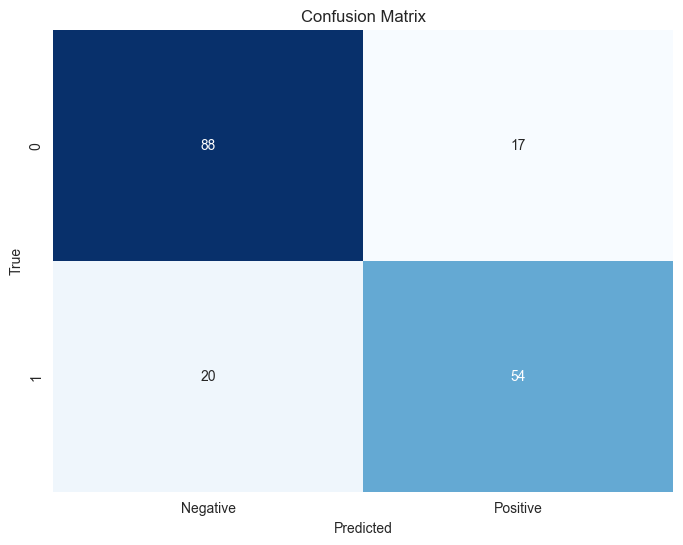

In [453]:
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)
create_confusion_matrix(predictions)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



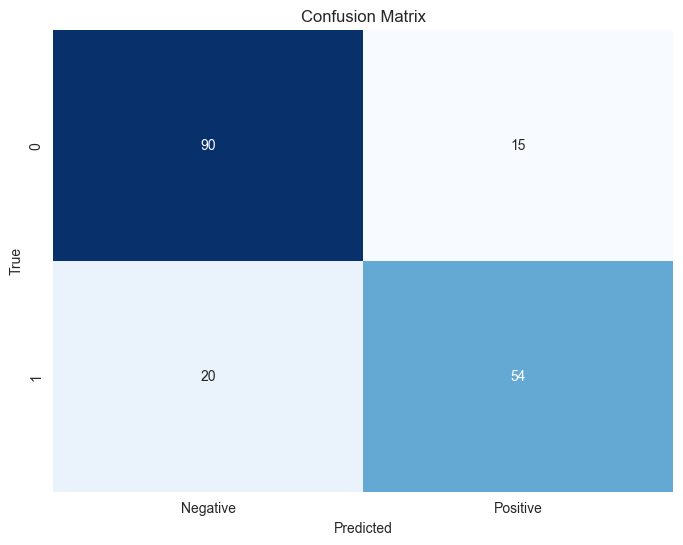

In [454]:
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)
create_confusion_matrix(predictions)

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       105
           1       0.75      0.57      0.65        74

    accuracy                           0.74       179
   macro avg       0.74      0.72      0.72       179
weighted avg       0.74      0.74      0.74       179



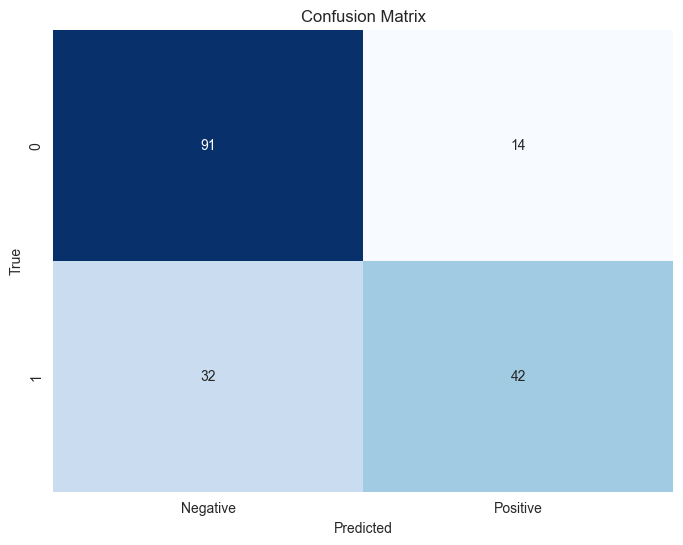

In [455]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)
create_confusion_matrix(predictions)

              precision    recall  f1-score   support

           0       0.70      0.90      0.78       105
           1       0.75      0.45      0.56        74

    accuracy                           0.71       179
   macro avg       0.72      0.67      0.67       179
weighted avg       0.72      0.71      0.69       179



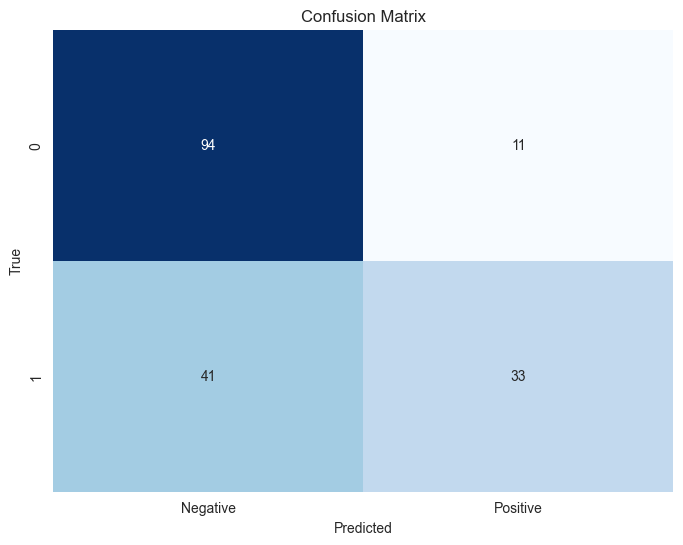

In [456]:
model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)
create_confusion_matrix(predictions)

Out of all models, the ones that performed the best was logistic regression predicting 142 values correctly and having f1 scores of 0.83 for negatives and 0.74 for positives, second place is taken by KNN with 133 correctly guessed values and last is Gaussian Naive Bayes. The models tend to perform better on predicting the negatives as there is more data and more people that did not survived the crash. For the next experiments, I will use Logistic Regression and Random Forrest.

# Finding outliers
## Finding 2 columns with greatest correlation for heatmanp

<Axes: >

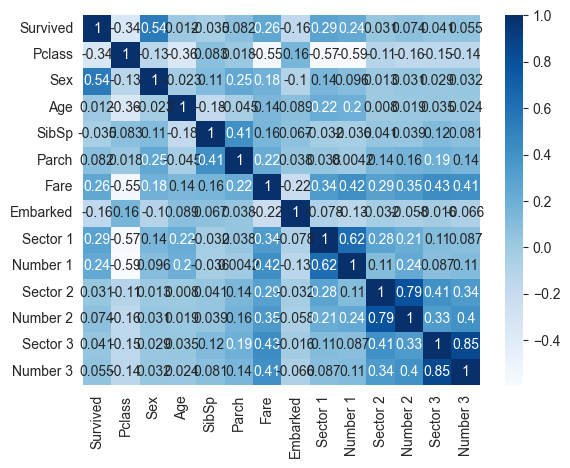

In [457]:
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.Blues)

As seen in this image, the most correlation columns are sex and pclass having a score of 0.54 and -0.34 respectively.
Probably because we have more data on number and sector 1, but these columns correlate a lot. 

## Training models for detection
We will try 4 models: Isolation Forest, OneClassSVM, EllipticEnvelope and LocalOutlierFactor

In [458]:
# Models
models = {
    "Isolation Forest": IsolationForest(contamination=0.1, random_state=42),
    "OneClassSVM": OneClassSVM(nu=0.1, kernel='rbf', gamma='scale'),
    "Elliptic Envelope": EllipticEnvelope(contamination=0.1, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.1)
}

outlier_preds = {}
for model_name, model in models.items():
    if model_name == "Local Outlier Factor":
        outlier_preds[model_name] = model.fit_predict(df[X_columns])
    else:
        model.fit(df[X_columns])
        outlier_preds[model_name] = model.predict(df[X_columns])

### Creating a scatter plot of the results

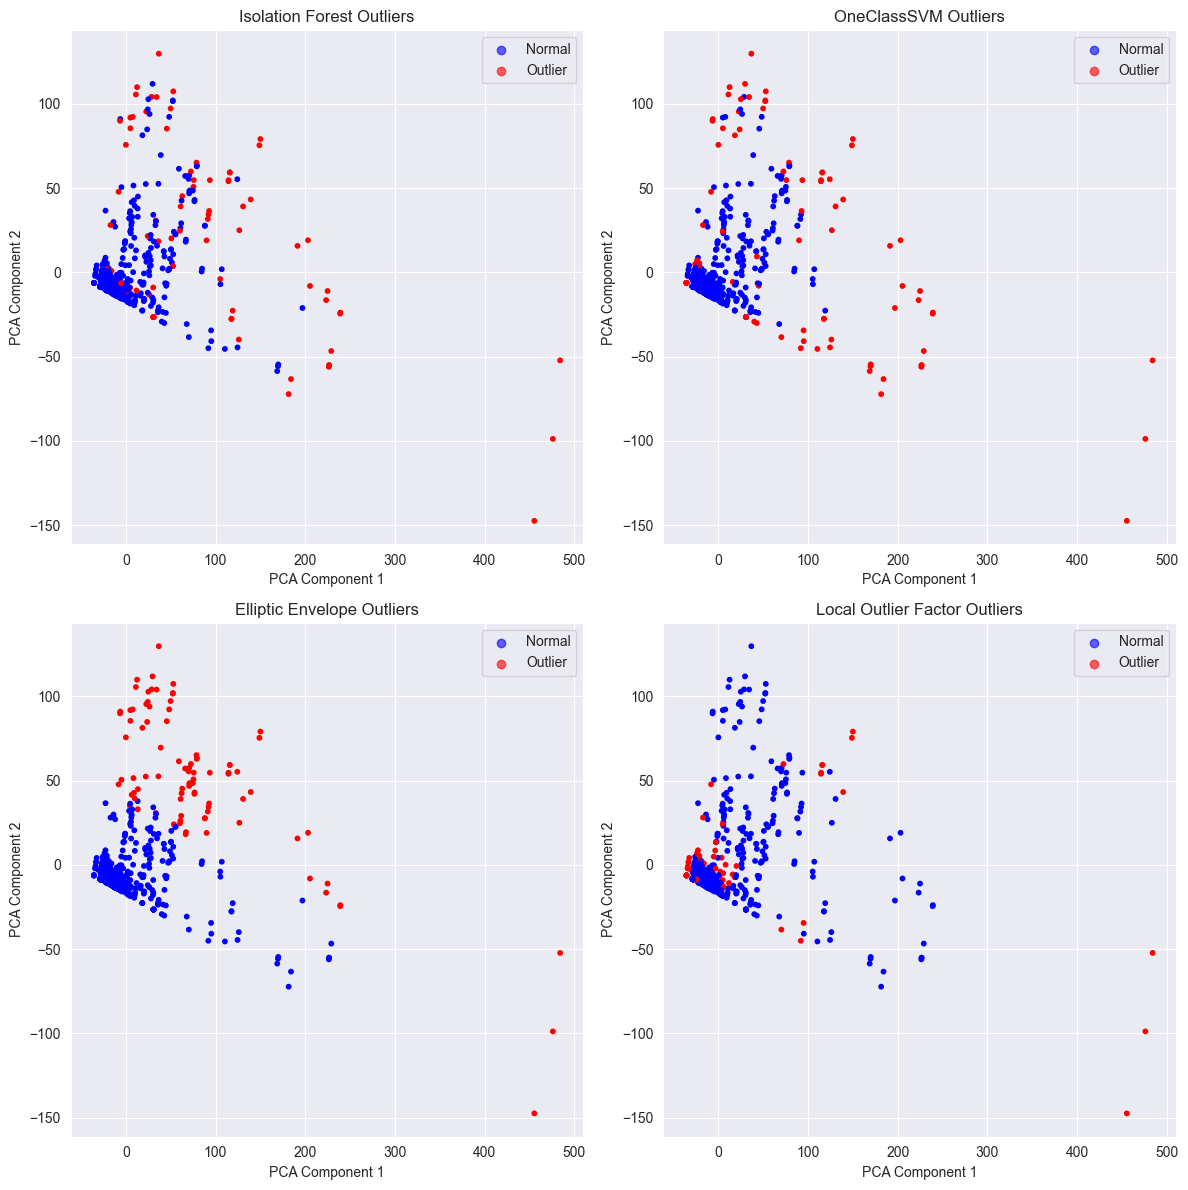

In [459]:
# PCA Transformation
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[X_columns])

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

model_names = list(models.keys())

for idx, (model_name, model) in enumerate(models.items()):
    ax = axes[idx // 2, idx % 2]

    outlier_pred = outlier_preds[model_name]
    
    colors = ['red' if label == -1 else 'blue' for label in outlier_pred]

    ax.scatter(df_pca[:, 0], df_pca[:, 1], c=colors, s=10)
    
    ax.set_title(f"{model_name} Outliers")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    
    ax.scatter([], [], color='blue', label='Normal', alpha=0.6)
    ax.scatter([], [], color='red', label='Outlier', alpha=0.6)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

Out of this plot, we see that each algorithm has given different results for outliers. There are 3 outliers, that are detected by every algorithm. Isolation Forest and OneClassSVM, seem to have more similar results than the others. I don't like how Elliptic Envelope worked, as it pretty much outlied a huge portion of our dataset, which doesn't seem reliable.  
## Training models with cleaned data
### OneClassSVM

In [460]:
outlier_model = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')

classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42)
}

outlier_model.fit(X_train[X_columns], y_train)
preds = outlier_model.predict(X_train[X_columns])
X_train_cleaned = X_train[preds == 1] 
y_train_cleaned = y_train[preds == 1]

results = []

for clf_name, clf_model in classification_models.items():
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    accuracy_orig = accuracy_score(y_test, y_pred)
    precision_orig = precision_score(y_test, y_pred)
    recall_orig = recall_score(y_test, y_pred)
    f1_orig = f1_score(y_test, y_pred)

    clf_model.fit(X_train_cleaned, y_train_cleaned)
    y_pred_cleaned = clf_model.predict(X_test)
    accuracy_cleaned = accuracy_score(y_test, y_pred_cleaned)
    precision_cleaned = precision_score(y_test, y_pred_cleaned)
    recall_cleaned = recall_score(y_test, y_pred_cleaned)
    f1_cleaned = f1_score(y_test, y_pred_cleaned)

    results.append({
        "Outlier Detection": "OneClassSVM",
        "Model": clf_name,
        "Accuracy Original": accuracy_orig, "Precision Original": precision_orig,
        "Recall Original": recall_orig, "F1 Original": f1_orig,
        "Accuracy Cleaned": accuracy_cleaned, "Precision Cleaned": precision_cleaned,
        "Recall Cleaned": recall_cleaned, "F1 Cleaned": f1_cleaned
    })

results_df = pd.DataFrame(results)
results_df

,Outlier Detection,Model,Accuracy Original,Precision Original,Recall Original,F1 Original,Accuracy Cleaned,Precision Cleaned,Recall Cleaned,F1 Cleaned
0,OneClassSVM,Logistic Regression,0.793296,0.760563,0.729730,0.744828,0.765363,0.722222,0.702703,0.712329
1,OneClassSVM,Random Forest Classifier,0.815642,0.797101,0.743243,0.769231,0.798883,0.771429,0.729730,0.750000


As seen in the table, accuracy and precision have been lowered while recall and f1 scores has been improved after cleaning outliers, which means as our recall increases, our precision decreases because, in addition to increasing the true positives, we increase the false positives.

### LocalOutlier


In [461]:
outlier_model = LocalOutlierFactor()

classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42)
}

preds = outlier_model.fit_predict(X_train[X_columns])
X_train_cleaned = X_train[preds == 1] 
y_train_cleaned = y_train[preds == 1]

for clf_name, clf_model in classification_models.items():
    clf_model.fit(X_train, y_train)
    y_pred = clf_model.predict(X_test)
    accuracy_orig = accuracy_score(y_test, y_pred)
    precision_orig = precision_score(y_test, y_pred)
    recall_orig = recall_score(y_test, y_pred)
    f1_orig = f1_score(y_test, y_pred)

    clf_model.fit(X_train_cleaned, y_train_cleaned)
    y_pred_cleaned = clf_model.predict(X_test)
    accuracy_cleaned = accuracy_score(y_test, y_pred_cleaned)
    precision_cleaned = precision_score(y_test, y_pred_cleaned)
    recall_cleaned = recall_score(y_test, y_pred_cleaned)
    f1_cleaned = f1_score(y_test, y_pred_cleaned)

    results.append({
        "Outlier Detection": "LocalOutlierFactor",
        "Model": clf_name,
        "Accuracy Original": accuracy_orig, "Precision Original": precision_orig,
        "Recall Original": recall_orig, "F1 Original": f1_orig,
        "Accuracy Cleaned": accuracy_cleaned, "Precision Cleaned": precision_cleaned,
        "Recall Cleaned": recall_cleaned, "F1 Cleaned": f1_cleaned
    })

results_df = pd.DataFrame(results)
results_df

,Outlier Detection,Model,Accuracy Original,Precision Original,Recall Original,F1 Original,Accuracy Cleaned,Precision Cleaned,Recall Cleaned,F1 Cleaned
0,OneClassSVM,Logistic Regression,0.793296,0.760563,0.729730,0.744828,0.765363,0.722222,0.702703,0.712329
1,OneClassSVM,Random Forest Classifier,0.815642,0.797101,0.743243,0.769231,0.798883,0.771429,0.729730,0.750000
2,LocalOutlierFactor,Logistic Regression,0.793296,0.760563,0.729730,0.744828,0.782123,0.746479,0.716216,0.731034
3,LocalOutlierFactor,Random Forest Classifier,0.815642,0.797101,0.743243,0.769231,0.770950,0.739130,0.689189,0.713287


- Outlier detection has improved precision (especially with LocalOutlierFactor) but reduced recall (some true positives missed).
- F1 score is highest with OneClassSVM + Random Forest on cleaned data (0.750). The second place is gotten by LocalOutlierFactor with logistic regression.
- To be noted, that these data scores can't be compared between different outlier detection algorithms as the datasets are different due to eliminating different outliers.

## Further improving our model 
Next I will use grid search on our OnceClassSVM cleaned dataset with Random Forest Classifier to further improve it.


In [462]:
preds = outlier_model.fit_predict(X_train[X_columns])
X_train_cleaned = X_train[preds == 1]
y_train_cleaned = y_train[preds == 1]

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=rf_param_grid,
                              cv=5,
                              n_jobs=-1,
                              scoring='accuracy')

rf_grid_search.fit(X_train, y_train)

best_rf_model = rf_grid_search.best_estimator_

In [463]:
best_rf_model

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=200,
                       random_state=42)

In [464]:
y_pred = best_rf_model.predict(X_test)
accuracy_orig = accuracy_score(y_test, y_pred)
precision_orig = precision_score(y_test, y_pred)
recall_orig = recall_score(y_test, y_pred)
f1_orig = f1_score(y_test, y_pred)

best_rf_model.fit(X_train_cleaned, y_train_cleaned)
y_pred_cleaned = best_rf_model.predict(X_test)
accuracy_cleaned = accuracy_score(y_test, y_pred_cleaned)
precision_cleaned = precision_score(y_test, y_pred_cleaned)
recall_cleaned = recall_score(y_test, y_pred_cleaned)
f1_cleaned = f1_score(y_test, y_pred_cleaned)

results.append({
    "Outlier Detection": "OneClassSVM",
    "Model": "Best Random Forest Classifier",
    "Accuracy Original": accuracy_orig, "Precision Original": precision_orig,
    "Recall Original": recall_orig, "F1 Original": f1_orig,
    "Accuracy Cleaned": accuracy_cleaned, "Precision Cleaned": precision_cleaned,
    "Recall Cleaned": recall_cleaned, "F1 Cleaned": f1_cleaned
})

results_df = pd.DataFrame(results)
results_df

,Outlier Detection,Model,Accuracy Original,Precision Original,Recall Original,F1 Original,Accuracy Cleaned,Precision Cleaned,Recall Cleaned,F1 Cleaned
0,OneClassSVM,Logistic Regression,0.793296,0.760563,0.729730,0.744828,0.765363,0.722222,0.702703,0.712329
1,OneClassSVM,Random Forest Classifier,0.815642,0.797101,0.743243,0.769231,0.798883,0.771429,0.729730,0.750000
2,LocalOutlierFactor,Logistic Regression,0.793296,0.760563,0.729730,0.744828,0.782123,0.746479,0.716216,0.731034
3,LocalOutlierFactor,Random Forest Classifier,0.815642,0.797101,0.743243,0.769231,0.770950,0.739130,0.689189,0.713287
4,OnceClassSVM,Best Random Forest Classifier,0.826816,0.820896,0.743243,0.780142,0.821229,0.818182,0.729730,0.771429


We see that the our last model outperforms the models having the best accuracy on cleand 82 and best f1 score 0.77 but the performance.

# Conclusion
In this study, I learned about different outlier methods: OneClassSVM, LocalOutlierFactor, Elliptic Envelope and Isolation Forest. It was hard for me to choose what method to use because some of them have similar results but some of them not. Also,  I liked the part of creating new features as it implies that you need to be creative with your data.